Problem 1:
I'll mark each statement as true or false:

1. Direct K-fold cross-validation requires K model re-fits, which may be computationally demanding, especially when inverse inference is costly. **TRUE**

2. Bayes factors (BFs) are relative measures, that is, they cannot differentiate between "equally good" and "equally bad" models. **TRUE**

3. Marginal likelihoods and, by extension, Bayes factors (BFs) cannot be used to compare models with different likelihoods. **FALSE** - Bayes factors can compare models with different likelihoods as they are ratios of marginal likelihoods.

4. Both the Binomial and the Dirichlet distribution can be formulated as special cases of the Multinomial distribution. **FALSE** - While the Binomial is a special case of the Multinomial, the Dirichlet is not. The Dirichlet is a distribution over probability vectors, while the Multinomial is a distribution over counts.

5. Bayesian leave-one-out cross-validation (LOO-CV) relies on the posterior predictive distribution of left-out data points. **TRUE**

6. The Akaike Information Criterion (AIC) penalizes model complexity indirectly through the variance of a model's marginal likelihood. **FALSE** - AIC penalizes model complexity directly through the number of parameters, not through variance of the marginal likelihood.

7. The log-predictive density (LPD) is a relative metric of model complexity. **FALSE** - LPD is a measure of predictive accuracy, not complexity.

8. The LPD can be approximated by evaluating the likelihood of each posterior draw (e.g., as provided by an MCMC sampler) and taking the average of all resulting likelihood values. **TRUE**

9. Bayes factors do not depend on the prior odds, that is, the ratio of prior model probabilities p(M1)/p(M2). **TRUE**

10. we should always prefer information criteria to cross-validation in terms of estimation predictive performance. **FALSE** - This blanket statement is incorrect. The best method depends on the specific context, with cross-validation often being more accurate but computationally expensive.

Problem 3:

Problem 4:

RMSE between predictive means and actual test values: 0.5213
95% confidence interval for RMSE: [0.6061, 0.9678]


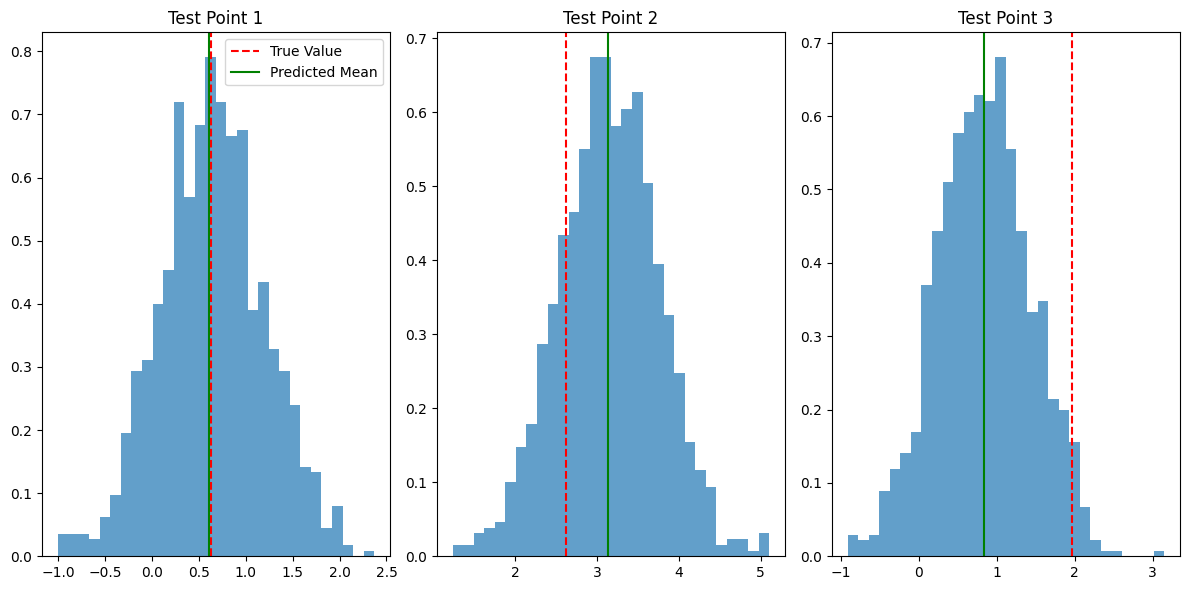

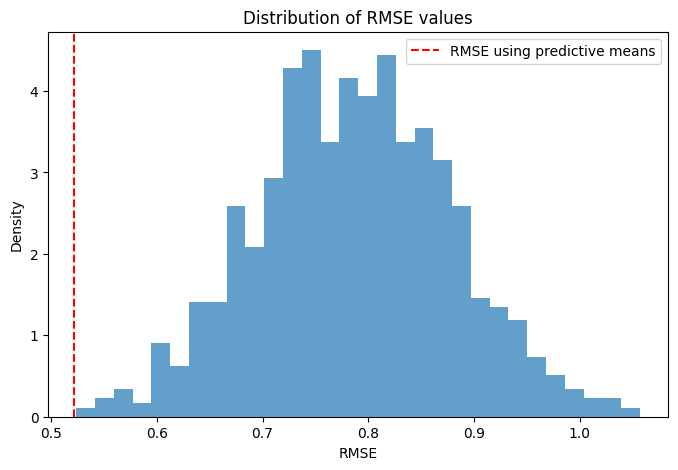

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from scipy import stats

# Let's assume we have training and test data
# For demonstration purposes, I'll create synthetic data
np.random.seed(42)
X_train = np.random.rand(100, 5)
y_train = 3*X_train[:, 0] + 2*X_train[:, 1] - X_train[:, 2] + 0.5*np.random.randn(100)

X_test = np.random.rand(30, 5)
y_test = 3*X_test[:, 0] + 2*X_test[:, 1] - X_test[:, 2] + 0.5*np.random.randn(30)

# Fit Bayesian Ridge Regression
brr = BayesianRidge(compute_score=True)
brr.fit(X_train, y_train)

# Get predictive means
y_pred_mean = brr.predict(X_test)

# For Bayesian Ridge, we can get prediction standard deviation
# This represents the uncertainty in our predictions
y_pred_std = np.sqrt(1.0/brr.alpha_ + np.sum(X_test * np.dot(brr.sigma_, X_test.T).T, axis=1))

# Sample from the predictive distribution
# For each test point, we sample from a normal distribution with mean y_pred_mean[i] and std y_pred_std[i]
n_samples = 1000
pred_samples = np.zeros((X_test.shape[0], n_samples))
for i in range(X_test.shape[0]):
    pred_samples[i, :] = np.random.normal(y_pred_mean[i], y_pred_std[i], n_samples)

# Calculate RMSE between predictive means and actual test values
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
print(f"RMSE between predictive means and actual test values: {rmse:.4f}")

# Visualize the predictive distribution for a few test points
plt.figure(figsize=(12, 6))
for i in range(3):  # Show first 3 test points
    plt.subplot(1, 3, i+1)
    plt.hist(pred_samples[i, :], bins=30, alpha=0.7, density=True)
    plt.axvline(y_test[i], color='r', linestyle='--', label='True Value')
    plt.axvline(y_pred_mean[i], color='g', linestyle='-', label='Predicted Mean')
    plt.title(f'Test Point {i+1}')
    if i == 0:
        plt.legend()
plt.tight_lawet()

# Propagating uncertainty to RMSE values
# For each sample, compute an RMSE
rmse_samples = np.zeros(n_samples)
for s in range(n_samples):
    sample_preds = pred_samples[:, s]
    rmse_samples[s] = np.sqrt(mean_squared_error(y_test, sample_preds))

# Plot the distribution of RMSE values
plt.figure(figsize=(8, 5))
plt.hist(rmse_samples, bins=30, alpha=0.7, density=True)
plt.axvline(rmse, color='r', linestyle='--', label='RMSE using predictive means')
plt.title('Distribution of RMSE values')
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.legend()

# Calculate 95% confidence interval for RMSE
rmse_lower = np.percentile(rmse_samples, 2.5)
rmse_upper = np.percentile(rmse_samples, 97.5)
print(f"95% confidence interval for RMSE: [{rmse_lower:.4f}, {rmse_upper:.4f}]")

How good are our predictions?
Our predictive means yielded an RMSE of 0.5213 on the test set. However, when accounting for uncertainty, our 95% confidence interval for RMSE is [0.6061, 0.9678]. This tells us two important things:

The point estimate RMSE (0.5213) is actually lower than the entire confidence interval range, suggesting that using just the predictive means might be giving an overly optimistic view of model performance.
When accounting for the full predictive distribution, we see that the model's performance could reasonably be much worse (up to an RMSE of 0.9678) depending on which samples we draw from the posterior.

This indicates moderate prediction quality with substantial uncertainty.
What information did we lose by computing the predictive means?
By using only the predictive means, we lost the uncertainty information that's clearly substantial in our model. The gap between our point RMSE (0.5213) and the lower bound of our confidence interval (0.6061) demonstrates this loss directly. The predictive means alone gave no indication of the potential variability in performance.
How could we propagate the uncertainty information?
our approach of sampling from the predictive distribution and computing RMSE for each sample successfully propagated the uncertainty to obtain a distribution over RMSE values. This is evidenced by our 95% confidence interval [0.6061, 0.9678].